In [1]:
from helpers import *
from dataset import *
from model2_for48 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
#DEBAG = False
DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

In [4]:
mask_size2 = {
    'defolt': 1,
    'apo-ferritin': mask_size["apo-ferritin"]*0.8,
    'beta-amylase':0,
    'beta-galactosidase': mask_size["beta-galactosidase"]*0.8,
    'ribosome': mask_size["ribosome"]*0.8,
    'thyroglobulin': mask_size["thyroglobulin"]*0.8,
    'virus-like-particle': mask_size["virus-like-particle"]*0.8,
}
print(mask_size2)
mask_check("TS_5_4",mask_size2,cfg)

{'defolt': 1, 'apo-ferritin': 4.800000000000001, 'beta-amylase': 0, 'beta-galactosidase': 7.2, 'ribosome': 12.0, 'thyroglobulin': 10.4, 'virus-like-particle': 10.8}
['TS_5_4']
 TS_5_4 virus-like-particle


(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
 0         apo-ferritin  41  46   37     9   4   0.902439  0.804348  0.809524   
 1         beta-amylase  10  10   10     0   0   1.000000  1.000000  1.000000   
 2   beta-galactosidase  12  12   12     0   0   1.000000  1.000000  1.000000   
 3             ribosome  30  31   29     2   1   0.966667  0.935484  0.937262   
 4        thyroglobulin  30  30   30     0   0   1.000000  1.000000  1.000000   
 5  virus-like-particle  11  11   11     0   0   1.000000  1.000000  1.000000   
 
    weight  
 0       1  
 1       0  
 2       2  
 3       1  
 4       2  
 5       1  ,
 0.963826595276894)

(3, 184, 630, 630)
(3, 184, 630, 630)


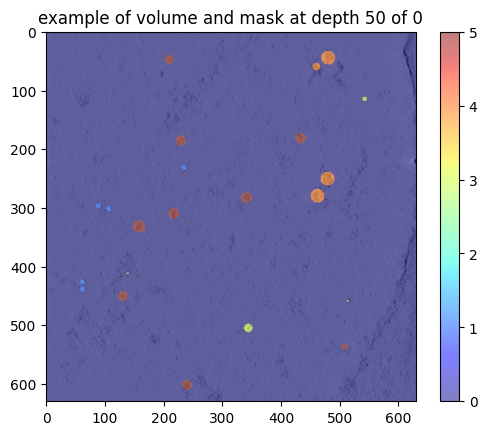

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4",'TS_99_9',"TS_6_4",]
test_id = ["TS_5_4",'TS_99_9',"TS_6_4",]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant", method="end"),
    
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

33
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


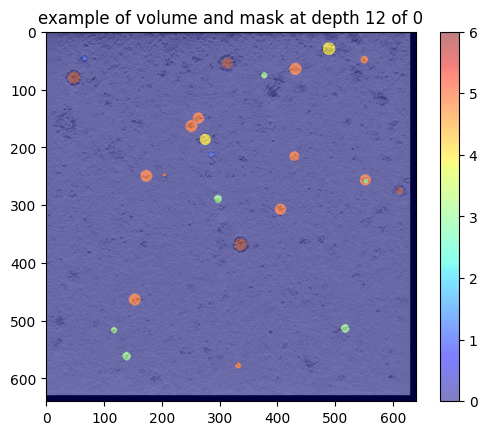

787841
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


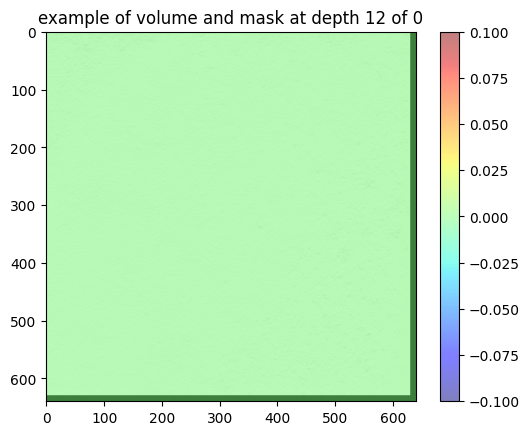

286


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 4
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:4


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
from tqdm import tqdm

# 学習ループにCV計算を追加
num_epochs = 300
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in tqdm(range(num_epochs)):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  0%|          | 0/300 [00:00<?, ?it/s]

エポック 1/300
----------
train_loss: 1.8666
valid_loss: 1.4728
CVスコア 0.0000
         particle_type     P    T  hit  precision  recall  f-beta4
0         apo-ferritin    12  140    0        0.0     0.0      0.0
1         beta-amylase     3   40    0        0.0     0.0      0.0
2   beta-galactosidase     4   48    0        0.0     0.0      0.0
3             ribosome     3  170    0        0.0     0.0      0.0
4        thyroglobulin  2898  109    0        0.0     0.0      0.0
5  virus-like-particle    12   34    0        0.0     0.0      0.0


  0%|          | 1/300 [01:09<5:44:27, 69.12s/it]

エポック 2/300
----------
train_loss: 1.6737


  1%|          | 2/300 [01:30<3:22:56, 40.86s/it]

エポック 3/300
----------
train_loss: 1.5668


  1%|          | 3/300 [01:51<2:37:58, 31.91s/it]

エポック 4/300
----------
train_loss: 1.4698


  1%|▏         | 4/300 [02:13<2:17:26, 27.86s/it]

エポック 5/300
----------
train_loss: 1.3626


  2%|▏         | 5/300 [02:34<2:05:51, 25.60s/it]

エポック 6/300
----------
train_loss: 1.2498
valid_loss: 1.1321
CVスコア 0.0000
         particle_type  P    T  hit  precision  recall  f-beta4
0         apo-ferritin  3  140    0        0.0     0.0      0.0
1         beta-amylase  3   40    0        0.0     0.0      0.0
2   beta-galactosidase  3   48    0        0.0     0.0      0.0
3             ribosome  3  170    0        0.0     0.0      0.0
4        thyroglobulin  3  109    0        0.0     0.0      0.0
5  virus-like-particle  3   34    0        0.0     0.0      0.0


  2%|▏         | 6/300 [03:43<3:17:46, 40.36s/it]

エポック 7/300
----------
train_loss: 1.1406


  2%|▏         | 7/300 [04:04<2:46:26, 34.08s/it]

エポック 8/300
----------
train_loss: 1.0357


  3%|▎         | 8/300 [04:26<2:25:51, 29.97s/it]

エポック 9/300
----------
train_loss: 0.9352


  3%|▎         | 9/300 [04:47<2:12:14, 27.27s/it]

エポック 10/300
----------
train_loss: 0.8385


  3%|▎         | 10/300 [05:08<2:03:13, 25.49s/it]

エポック 11/300
----------
train_loss: 0.7572
valid_loss: 0.6439
CVスコア 0.0000
         particle_type    P    T  hit  precision  recall  f-beta4
0         apo-ferritin    3  140    0        0.0     0.0      0.0
1         beta-amylase    3   40    0        0.0     0.0      0.0
2   beta-galactosidase    3   48    0        0.0     0.0      0.0
3             ribosome    3  170    0        0.0     0.0      0.0
4        thyroglobulin  338  109    0        0.0     0.0      0.0
5  virus-like-particle    3   34    0        0.0     0.0      0.0


  4%|▎         | 11/300 [06:18<3:07:55, 39.01s/it]

エポック 12/300
----------
train_loss: 0.6741


  4%|▍         | 12/300 [06:40<2:41:58, 33.74s/it]

エポック 13/300
----------
train_loss: 0.5919


  4%|▍         | 13/300 [07:01<2:23:56, 30.09s/it]

エポック 14/300
----------
train_loss: 0.5150


  5%|▍         | 14/300 [07:23<2:11:08, 27.51s/it]

エポック 15/300
----------
train_loss: 0.4456


  5%|▌         | 15/300 [07:44<2:01:57, 25.67s/it]

エポック 16/300
----------
train_loss: 0.3837
valid_loss: 0.4501
CVスコア 0.0051
         particle_type      P    T  hit  precision    recall   f-beta4
0         apo-ferritin   7490  140    0   0.000000  0.000000  0.000000
1         beta-amylase      3   40    0   0.000000  0.000000  0.000000
2   beta-galactosidase  15776   48   12   0.000761  0.250000  0.012331
3             ribosome      3  170    0   0.000000  0.000000  0.000000
4        thyroglobulin    229  109    0   0.000000  0.000000  0.000000
5  virus-like-particle   7240   34    5   0.000691  0.147059  0.010920


  5%|▌         | 16/300 [08:53<3:03:16, 38.72s/it]

エポック 17/300
----------
train_loss: 0.3303


  6%|▌         | 17/300 [09:15<2:37:45, 33.45s/it]

エポック 18/300
----------
train_loss: 0.2854


  6%|▌         | 18/300 [09:36<2:20:22, 29.87s/it]

エポック 19/300
----------
train_loss: 0.2496


  6%|▋         | 19/300 [09:58<2:08:02, 27.34s/it]

エポック 20/300
----------
train_loss: 0.2209


  7%|▋         | 20/300 [10:19<1:59:19, 25.57s/it]

エポック 21/300
----------
train_loss: 0.1975
valid_loss: 0.1921
CVスコア 0.1546
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin  1011  140    5   0.004946  0.035714  0.026146
1         beta-amylase  1214   40   13   0.010708  0.325000  0.119202
2   beta-galactosidase   501   48   14   0.027944  0.291667  0.187549
3             ribosome  2529  170   16   0.006327  0.094118  0.051819
4        thyroglobulin   423  109   31   0.073286  0.284404  0.243193
5  virus-like-particle   528   34    9   0.017045  0.264706  0.142724


  7%|▋         | 21/300 [11:25<2:55:38, 37.77s/it]

エポック 22/300
----------
train_loss: 0.1804


  7%|▋         | 22/300 [11:47<2:32:48, 32.98s/it]

エポック 23/300
----------
train_loss: 0.1644


  8%|▊         | 23/300 [12:08<2:16:03, 29.47s/it]

エポック 24/300
----------
train_loss: 0.1505


  8%|▊         | 24/300 [12:30<2:04:24, 27.04s/it]

エポック 25/300
----------
train_loss: 0.1395


  8%|▊         | 25/300 [12:51<1:56:26, 25.40s/it]

エポック 26/300
----------
train_loss: 0.1302


  9%|▊         | 26/300 [13:55<2:48:59, 37.01s/it]

valid_loss: 0.1278
CVスコア 0.1495
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  636  140    5   0.007862  0.035714  0.029555
1         beta-amylase  689   40    7   0.010160  0.175000  0.089541
2   beta-galactosidase  363   48   11   0.030303  0.229167  0.165340
3             ribosome  759  170   15   0.019763  0.088235  0.073297
4        thyroglobulin  437  109   33   0.075515  0.302752  0.257221
5  virus-like-particle  316   34    5   0.015823  0.147059  0.098837
エポック 27/300
----------


  9%|▉         | 27/300 [14:15<2:24:46, 31.82s/it]

train_loss: 0.1219
エポック 28/300
----------


  9%|▉         | 28/300 [14:35<2:08:09, 28.27s/it]

train_loss: 0.1149
エポック 29/300
----------


 10%|▉         | 29/300 [14:55<1:56:29, 25.79s/it]

train_loss: 0.1081
エポック 30/300
----------


 10%|█         | 30/300 [15:15<1:48:13, 24.05s/it]

train_loss: 0.1024
エポック 31/300
----------
train_loss: 0.0980


 10%|█         | 31/300 [16:18<2:40:44, 35.85s/it]

valid_loss: 0.0960
CVスコア 0.0050
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  617  140    0   0.000000  0.000000  0.000000
1         beta-amylase  845   40    5   0.005917  0.125000  0.057239
2   beta-galactosidase   38   48    0   0.000000  0.000000  0.000000
3             ribosome  687  170    7   0.010189  0.041176  0.034928
4        thyroglobulin   71  109    0   0.000000  0.000000  0.000000
5  virus-like-particle   26   34    0   0.000000  0.000000  0.000000
エポック 32/300
----------


 11%|█         | 32/300 [16:38<2:18:28, 31.00s/it]

train_loss: 0.0926
エポック 33/300
----------


 11%|█         | 33/300 [16:58<2:03:15, 27.70s/it]

train_loss: 0.0886
エポック 34/300
----------


 11%|█▏        | 34/300 [17:18<1:52:29, 25.37s/it]

train_loss: 0.0849
エポック 35/300
----------


 12%|█▏        | 35/300 [17:38<1:44:49, 23.74s/it]

train_loss: 0.0822
エポック 36/300
----------
train_loss: 0.0792
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 12%|█▏        | 36/300 [18:40<2:35:32, 35.35s/it]

location_df is empty, 
valid_loss: 0.0976
CVスコア 0.0295
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  349  36    0   0.000000  0.000000  0.000000
1         beta-amylase  342  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    7  24    0   0.000000  0.000000  0.000000
3             ribosome  276  65   16   0.057971  0.246154  0.206687
4        thyroglobulin    0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle    0  13    0   0.000000  0.000000  0.000000
エポック 37/300
----------


 12%|█▏        | 37/300 [19:00<2:14:16, 30.63s/it]

train_loss: 0.0764
エポック 38/300
----------


 13%|█▎        | 38/300 [19:20<1:59:42, 27.42s/it]

train_loss: 0.0739
エポック 39/300
----------


 13%|█▎        | 39/300 [19:40<1:49:32, 25.18s/it]

train_loss: 0.0721
エポック 40/300
----------


 13%|█▎        | 40/300 [20:00<1:42:30, 23.65s/it]

train_loss: 0.0700
エポック 41/300
----------
train_loss: 0.0679
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 14%|█▎        | 41/300 [21:02<2:32:20, 35.29s/it]

location_df is empty, 
valid_loss: 0.0779
CVスコア 0.0221
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  540  36    4   0.007407  0.111111  0.060932
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  405  65    8   0.019753  0.123077  0.094118
4        thyroglobulin    0  49    0   0.000000  0.000000  0.000000
5  virus-like-particle    0  13    0   0.000000  0.000000  0.000000
エポック 42/300
----------


 14%|█▍        | 42/300 [21:22<2:11:40, 30.62s/it]

train_loss: 0.0659
エポック 43/300
----------


 14%|█▍        | 43/300 [21:42<1:57:16, 27.38s/it]

train_loss: 0.0640
エポック 44/300
----------


 15%|█▍        | 44/300 [22:02<1:47:11, 25.12s/it]

train_loss: 0.0627
エポック 45/300
----------


 15%|█▌        | 45/300 [22:22<1:40:11, 23.57s/it]

train_loss: 0.0610
エポック 46/300
----------
train_loss: 0.0594
location_df is empty, 
location_df is empty, 


 15%|█▌        | 46/300 [23:24<2:29:01, 35.20s/it]

location_df is empty, 
particle_type not found, skipping groupby.
valid_loss: 0.0772
CVスコア 0.0000
Empty DataFrame
Columns: [particle_type, P, T, hit, precision, recall, f-beta4]
Index: []
エポック 47/300
----------


 16%|█▌        | 47/300 [23:44<2:08:52, 30.56s/it]

train_loss: 0.0580
エポック 48/300
----------


 16%|█▌        | 48/300 [24:04<1:55:03, 27.40s/it]

train_loss: 0.0572
エポック 49/300
----------


 16%|█▋        | 49/300 [24:24<1:45:17, 25.17s/it]

train_loss: 0.0553
エポック 50/300
----------


 17%|█▋        | 50/300 [24:44<1:38:21, 23.61s/it]

train_loss: 0.0542
エポック 51/300
----------
train_loss: 0.0529


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 17%|█▋        | 51/300 [25:47<2:27:01, 35.43s/it]

location_df is empty, 
valid_loss: 0.0764
CVスコア 0.0436
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  129  82    0   0.000000  0.000000  0.000000
1         beta-amylase   14  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  436  96   31   0.071101  0.322917  0.267241
4        thyroglobulin   11  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   65  24    1   0.015385  0.041667  0.037862
エポック 52/300
----------


 17%|█▋        | 52/300 [26:07<2:07:02, 30.74s/it]

train_loss: 0.0522
エポック 53/300
----------


 18%|█▊        | 53/300 [26:27<1:53:10, 27.49s/it]

train_loss: 0.0515
エポック 54/300
----------


 18%|█▊        | 54/300 [26:47<1:43:35, 25.27s/it]

train_loss: 0.0502
エポック 55/300
----------


 18%|█▊        | 55/300 [27:07<1:36:47, 23.71s/it]

train_loss: 0.0493
エポック 56/300
----------
train_loss: 0.0493
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 19%|█▊        | 56/300 [28:10<2:24:05, 35.43s/it]

location_df is empty, 
valid_loss: 0.0810
CVスコア 0.0666
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin    35  36    0   0.000000  0.000000  0.000000
1         beta-amylase     1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0  24    0   0.000000  0.000000  0.000000
3             ribosome   250  65   12   0.048000  0.184615  0.158140
4        thyroglobulin  1867  49   24   0.012855  0.489796  0.153904
5  virus-like-particle    19  13    0   0.000000  0.000000  0.000000
エポック 57/300
----------


 19%|█▉        | 57/300 [28:29<2:04:27, 30.73s/it]

train_loss: 0.0479
エポック 58/300
----------


 19%|█▉        | 58/300 [28:49<1:50:55, 27.50s/it]

train_loss: 0.0466
エポック 59/300
----------


 20%|█▉        | 59/300 [29:09<1:41:22, 25.24s/it]

train_loss: 0.0461
エポック 60/300
----------


 20%|██        | 60/300 [29:29<1:34:36, 23.65s/it]

train_loss: 0.0445
エポック 61/300
----------
train_loss: 0.0440
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 20%|██        | 61/300 [30:33<2:22:00, 35.65s/it]

location_df is empty, 
valid_loss: 0.1104
CVスコア 0.0194
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1184  36    1   0.000845  0.027778  0.009659
1         beta-amylase   616  21    1   0.001623  0.047619  0.017857
2   beta-galactosidase    25  24    0   0.000000  0.000000  0.000000
3             ribosome   258  65    1   0.003876  0.015385  0.013097
4        thyroglobulin  1141  49    2   0.001753  0.040816  0.017662
5  virus-like-particle  1099  13    6   0.005460  0.461538  0.078041
エポック 62/300
----------


 21%|██        | 62/300 [30:53<2:02:26, 30.87s/it]

train_loss: 0.0440
エポック 63/300
----------


 21%|██        | 63/300 [31:12<1:48:46, 27.54s/it]

train_loss: 0.0426
エポック 64/300
----------


 21%|██▏       | 64/300 [31:32<1:39:19, 25.25s/it]

train_loss: 0.0408
エポック 65/300
----------


 22%|██▏       | 65/300 [31:52<1:32:43, 23.67s/it]

train_loss: 0.0391
エポック 66/300
----------
train_loss: 0.0384
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 22%|██▏       | 66/300 [32:55<2:18:09, 35.43s/it]

location_df is empty, 
valid_loss: 0.2576
CVスコア 0.0611
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   36  36    0   0.000000  0.000000  0.000000
1         beta-amylase   98  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  382  65    0   0.000000  0.000000  0.000000
4        thyroglobulin  204  49    1   0.004902  0.020408  0.017206
5  virus-like-particle  311  13   12   0.038585  0.923077  0.393064
エポック 67/300
----------


 22%|██▏       | 67/300 [33:15<1:59:16, 30.72s/it]

train_loss: 0.0378
エポック 68/300
----------


 23%|██▎       | 68/300 [33:35<1:46:11, 27.46s/it]

train_loss: 0.0370
エポック 69/300
----------


 23%|██▎       | 69/300 [33:55<1:37:07, 25.23s/it]

train_loss: 0.0372
エポック 70/300
----------


 23%|██▎       | 70/300 [34:15<1:30:43, 23.67s/it]

train_loss: 0.0373
エポック 71/300
----------
train_loss: 0.0377
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 24%|██▎       | 71/300 [35:18<2:15:12, 35.43s/it]

valid_loss: 0.2263
CVスコア 0.0018
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin    2   94    0   0.000000  0.000000  0.000000
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0   36    0   0.000000  0.000000  0.000000
3             ribosome  423  139    2   0.004728  0.014388  0.012845
4        thyroglobulin  171   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   59   23    0   0.000000  0.000000  0.000000
エポック 72/300
----------


 24%|██▍       | 72/300 [35:37<1:56:42, 30.71s/it]

train_loss: 0.0360
エポック 73/300
----------


 24%|██▍       | 73/300 [35:57<1:44:05, 27.51s/it]

train_loss: 0.0355
エポック 74/300
----------


 25%|██▍       | 74/300 [36:17<1:35:03, 25.24s/it]

train_loss: 0.0352
エポック 75/300
----------


 25%|██▌       | 75/300 [36:37<1:28:42, 23.65s/it]

train_loss: 0.0332
エポック 76/300
----------
train_loss: 0.0325
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 25%|██▌       | 76/300 [37:42<2:14:07, 35.93s/it]

valid_loss: 0.1786
CVスコア 0.0464
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin   177   94    0   0.000000  0.000000  0.000000
1         beta-amylase    56   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase     0   36    0   0.000000  0.000000  0.000000
3             ribosome   415  139    7   0.016867  0.050360  0.045093
4        thyroglobulin  1123   79   12   0.010686  0.151899  0.085463
5  virus-like-particle   726   23    7   0.009642  0.304348  0.108775
エポック 77/300
----------


 26%|██▌       | 77/300 [38:01<1:55:27, 31.07s/it]

train_loss: 0.0320
エポック 78/300
----------


 26%|██▌       | 78/300 [38:21<1:42:36, 27.73s/it]

train_loss: 0.0312
エポック 79/300
----------


 26%|██▋       | 79/300 [38:41<1:33:34, 25.40s/it]

train_loss: 0.0315
エポック 80/300
----------


 27%|██▋       | 80/300 [39:02<1:27:21, 23.82s/it]

train_loss: 0.0305
エポック 81/300
----------
train_loss: 0.0312
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 27%|██▋       | 81/300 [40:05<2:09:57, 35.60s/it]

valid_loss: 0.1546
CVスコア 0.0847
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin    0   94    0   0.000000  0.000000  0.000000
1         beta-amylase   11   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0   36    0   0.000000  0.000000  0.000000
3             ribosome   68  139   14   0.205882  0.100719  0.103839
4        thyroglobulin  134   79    6   0.044776  0.075949  0.072961
5  virus-like-particle  127   23   10   0.078740  0.434783  0.343434
エポック 82/300
----------


 27%|██▋       | 82/300 [40:24<1:52:11, 30.88s/it]

train_loss: 0.0304
エポック 83/300
----------


 28%|██▊       | 83/300 [40:44<1:39:45, 27.58s/it]

train_loss: 0.0291
エポック 84/300
----------


 28%|██▊       | 84/300 [41:04<1:30:58, 25.27s/it]

train_loss: 0.0281
エポック 85/300
----------


 28%|██▊       | 85/300 [41:24<1:24:49, 23.67s/it]

train_loss: 0.0280
エポック 86/300
----------
train_loss: 0.0281


 29%|██▊       | 86/300 [42:27<2:06:49, 35.56s/it]

valid_loss: 0.1097
CVスコア 0.0539
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin    0  140    0   0.000000  0.000000  0.000000
1         beta-amylase   12   40    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0   48    0   0.000000  0.000000  0.000000
3             ribosome  169  170   16   0.094675  0.094118  0.094150
4        thyroglobulin   15  109    0   0.000000  0.000000  0.000000
5  virus-like-particle   57   34   10   0.175439  0.294118  0.282862
エポック 87/300
----------


 29%|██▉       | 87/300 [42:47<1:49:25, 30.83s/it]

train_loss: 0.0304
エポック 88/300
----------


 29%|██▉       | 88/300 [43:07<1:37:20, 27.55s/it]

train_loss: 0.0297
エポック 89/300
----------


 30%|██▉       | 89/300 [43:27<1:28:53, 25.28s/it]

train_loss: 0.0286
エポック 90/300
----------


 30%|███       | 90/300 [43:47<1:22:55, 23.69s/it]

train_loss: 0.0265
エポック 91/300
----------
train_loss: 0.0252
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 30%|███       | 91/300 [44:50<2:03:20, 35.41s/it]

location_df is empty, 
valid_loss: 0.2028
CVスコア 0.0351
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  36    0   0.000000  0.000000  0.000000
1         beta-amylase   15  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  157  65    1   0.006369  0.015385  0.014202
4        thyroglobulin  149  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  379  13    8   0.021108  0.615385  0.231687
エポック 92/300
----------


 31%|███       | 92/300 [45:10<1:46:23, 30.69s/it]

train_loss: 0.0244
エポック 93/300
----------


 31%|███       | 93/300 [45:29<1:34:42, 27.45s/it]

train_loss: 0.0246
エポック 94/300
----------


 31%|███▏      | 94/300 [45:49<1:26:32, 25.21s/it]

train_loss: 0.0239
エポック 95/300
----------


 32%|███▏      | 95/300 [46:09<1:20:43, 23.63s/it]

train_loss: 0.0241
エポック 96/300
----------
train_loss: 0.0242
location_df is empty, 
location_df is empty, 
valid_loss: 0.1554
CVスコア 0.1966
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   0  36    0   0.000000  0.000000  0.000000
1         beta-amylase  10  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  90  65   34   0.377778  0.523077  0.511504
4        thyroglobulin   9  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  28  13   12   0.428571  0.923077  0.864407


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 32%|███▏      | 96/300 [47:14<2:01:44, 35.80s/it]

エポック 97/300
----------
train_loss: 0.0240


 32%|███▏      | 97/300 [47:35<1:46:08, 31.37s/it]

エポック 98/300
----------
train_loss: 0.0224


 33%|███▎      | 98/300 [47:56<1:35:21, 28.32s/it]

エポック 99/300
----------
train_loss: 0.0223


 33%|███▎      | 99/300 [48:17<1:27:50, 26.22s/it]

エポック 100/300
----------
train_loss: 0.0230


 33%|███▎      | 100/300 [48:39<1:22:37, 24.79s/it]

エポック 101/300
----------
train_loss: 0.0237
location_df is empty, 
location_df is empty, 
valid_loss: 0.2041
CVスコア 0.2021
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   70  36    3   0.042857  0.083333  0.078947
1         beta-amylase   45  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome  207  65   46   0.222222  0.707692  0.627105
4        thyroglobulin  138  49    2   0.014493  0.040816  0.036876
5  virus-like-particle  140  13   13   0.092857  1.000000  0.635057


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 34%|███▎      | 101/300 [49:43<2:01:30, 36.64s/it]

エポック 102/300
----------
train_loss: 0.0226


 34%|███▍      | 102/300 [50:04<1:45:30, 31.97s/it]

エポック 103/300
----------
train_loss: 0.0222


 34%|███▍      | 103/300 [50:25<1:34:25, 28.76s/it]

エポック 104/300
----------
train_loss: 0.0200


 35%|███▍      | 104/300 [50:46<1:26:34, 26.50s/it]

エポック 105/300
----------
train_loss: 0.0210


 35%|███▌      | 105/300 [51:08<1:21:12, 24.99s/it]

エポック 106/300
----------
train_loss: 0.0200
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 35%|███▌      | 106/300 [52:11<1:57:43, 36.41s/it]

valid_loss: 0.2208
CVスコア 0.0562
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   22   94    0   0.000000  0.000000  0.000000
1         beta-amylase   16   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0   36    0   0.000000  0.000000  0.000000
3             ribosome  121  139   10   0.082645  0.071942  0.072495
4        thyroglobulin  221   79    1   0.004525  0.012658  0.011448
5  virus-like-particle  260   23   11   0.042308  0.478261  0.297771
エポック 107/300
----------


 36%|███▌      | 107/300 [52:31<1:40:58, 31.39s/it]

train_loss: 0.0205
エポック 108/300
----------


 36%|███▌      | 108/300 [52:51<1:29:25, 27.94s/it]

train_loss: 0.0209
エポック 109/300
----------


 36%|███▋      | 109/300 [53:11<1:21:18, 25.54s/it]

train_loss: 0.0203
エポック 110/300
----------


 37%|███▋      | 110/300 [53:30<1:15:32, 23.85s/it]

train_loss: 0.0205
エポック 111/300
----------
train_loss: 0.0197
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 37%|███▋      | 111/300 [54:34<1:52:28, 35.71s/it]

valid_loss: 0.3245
CVスコア 0.0180
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  189   94    1   0.005291  0.010638  0.010041
1         beta-amylase    1   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   49   36    0   0.000000  0.000000  0.000000
3             ribosome   89  139    0   0.000000  0.000000  0.000000
4        thyroglobulin  391   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  219   23    4   0.018265  0.173913  0.115843
エポック 112/300
----------


 37%|███▋      | 112/300 [54:53<1:36:47, 30.89s/it]

train_loss: 0.0186
エポック 113/300
----------


 38%|███▊      | 113/300 [55:13<1:26:00, 27.59s/it]

train_loss: 0.0186
エポック 114/300
----------


 38%|███▊      | 114/300 [55:33<1:18:24, 25.29s/it]

train_loss: 0.0175
エポック 115/300
----------


 38%|███▊      | 115/300 [55:53<1:13:00, 23.68s/it]

train_loss: 0.0170
エポック 116/300
----------
train_loss: 0.0167
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 39%|███▊      | 116/300 [56:56<1:48:41, 35.44s/it]

valid_loss: 0.1500
CVスコア 0.1231
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  398   94   15   0.037688  0.159574  0.134069
1         beta-amylase   30   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   73   36    1   0.013699  0.027778  0.026194
3             ribosome  120  139   27   0.225000  0.194245  0.195819
4        thyroglobulin  254   79    7   0.027559  0.088608  0.078393
5  virus-like-particle  212   23   11   0.051887  0.478261  0.322414
エポック 117/300
----------


 39%|███▉      | 117/300 [57:16<1:33:43, 30.73s/it]

train_loss: 0.0167
エポック 118/300
----------


 39%|███▉      | 118/300 [57:36<1:23:17, 27.46s/it]

train_loss: 0.0175
エポック 119/300
----------


 40%|███▉      | 119/300 [57:56<1:15:59, 25.19s/it]

train_loss: 0.0160
エポック 120/300
----------


 40%|████      | 120/300 [58:15<1:10:50, 23.61s/it]

train_loss: 0.0162
エポック 121/300
----------
train_loss: 0.0174
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 40%|████      | 121/300 [59:18<1:45:43, 35.44s/it]

valid_loss: 0.2214
CVスコア 0.1132
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin  2096   94   15   0.007156  0.159574  0.070833
1         beta-amylase   920   30   12   0.013043  0.400000  0.145714
2   beta-galactosidase   656   36    9   0.013720  0.250000  0.124188
3             ribosome     6  139    2   0.333333  0.014388  0.015247
4        thyroglobulin  1483   79   21   0.014160  0.265823  0.129960
5  virus-like-particle   405   23    9   0.022222  0.391304  0.197930
エポック 122/300
----------


 41%|████      | 122/300 [59:38<1:31:05, 30.70s/it]

train_loss: 0.0158
エポック 123/300
----------


 41%|████      | 123/300 [59:58<1:20:57, 27.44s/it]

train_loss: 0.0164
エポック 124/300
----------


 41%|████▏     | 124/300 [1:00:18<1:13:55, 25.20s/it]

train_loss: 0.0157
エポック 125/300
----------


 42%|████▏     | 125/300 [1:00:38<1:09:06, 23.70s/it]

train_loss: 0.0153
エポック 126/300
----------
train_loss: 0.0152
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 42%|████▏     | 126/300 [1:01:42<1:43:16, 35.61s/it]

valid_loss: 0.1539
CVスコア 0.1500
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  899   94   16   0.017798  0.170213  0.113192
1         beta-amylase  214   30    2   0.009346  0.066667  0.048991
2   beta-galactosidase  219   36    7   0.031963  0.194444  0.149686
3             ribosome   94  139   22   0.234043  0.158273  0.161346
4        thyroglobulin  375   79    3   0.008000  0.037975  0.031117
5  virus-like-particle  125   23   12   0.096000  0.521739  0.413793
エポック 127/300
----------


 42%|████▏     | 127/300 [1:02:01<1:29:04, 30.89s/it]

train_loss: 0.0143
エポック 128/300
----------


 43%|████▎     | 128/300 [1:02:21<1:19:04, 27.59s/it]

train_loss: 0.0144
エポック 129/300
----------


 43%|████▎     | 129/300 [1:02:41<1:12:07, 25.31s/it]

train_loss: 0.0137
エポック 130/300
----------


 43%|████▎     | 130/300 [1:03:01<1:07:16, 23.74s/it]

train_loss: 0.0134
エポック 131/300
----------
train_loss: 0.0126
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 44%|████▎     | 131/300 [1:04:05<1:40:16, 35.60s/it]

valid_loss: 0.1371
CVスコア 0.1480
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  588   94   28   0.047619  0.297872  0.227533
1         beta-amylase   52   30    1   0.019231  0.033333  0.031955
2   beta-galactosidase  221   36    6   0.027149  0.166667  0.127980
3             ribosome  115  139   18   0.156522  0.129496  0.130825
4        thyroglobulin  144   79    1   0.006944  0.012658  0.012074
5  virus-like-particle   60   23   10   0.166667  0.434783  0.397196
エポック 132/300
----------


 44%|████▍     | 132/300 [1:04:24<1:26:23, 30.85s/it]

train_loss: 0.0137
エポック 133/300
----------


 44%|████▍     | 133/300 [1:04:44<1:16:39, 27.54s/it]

train_loss: 0.0130
エポック 134/300
----------


 45%|████▍     | 134/300 [1:05:04<1:09:47, 25.23s/it]

train_loss: 0.0122
エポック 135/300
----------


 45%|████▌     | 135/300 [1:05:24<1:05:02, 23.65s/it]

train_loss: 0.0124
エポック 136/300
----------
train_loss: 0.0124
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 45%|████▌     | 136/300 [1:06:27<1:37:04, 35.52s/it]

valid_loss: 0.1239
CVスコア 0.1452
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   52   94   20   0.384615  0.212766  0.218509
1         beta-amylase    4   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   31   36    0   0.000000  0.000000  0.000000
3             ribosome  146  139   50   0.342466  0.359712  0.358650
4        thyroglobulin   41   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   19   23   10   0.526316  0.434783  0.439276
エポック 137/300
----------


 46%|████▌     | 137/300 [1:06:47<1:23:39, 30.80s/it]

train_loss: 0.0122
エポック 138/300
----------


 46%|████▌     | 138/300 [1:07:07<1:14:19, 27.53s/it]

train_loss: 0.0117
エポック 139/300
----------


 46%|████▋     | 139/300 [1:07:27<1:07:54, 25.31s/it]

train_loss: 0.0121
エポック 140/300
----------


 47%|████▋     | 140/300 [1:07:47<1:03:15, 23.72s/it]

train_loss: 0.0136
エポック 141/300
----------
train_loss: 0.0137
location_df is empty, 
location_df is empty, 
valid_loss: 0.1908
CVスコア 0.2480
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1246  36   21   0.016854  0.583333  0.195939
1         beta-amylase    15  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   975  24   13   0.013333  0.541667  0.162620
3             ribosome   107  65   30   0.280374  0.461538  0.444638
4        thyroglobulin    61  49    0   0.000000  0.000000  0.000000
5  virus-like-particle    79  13   13   0.164557  1.000000  0.770035


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 47%|████▋     | 141/300 [1:08:51<1:35:12, 35.93s/it]

エポック 142/300
----------
train_loss: 0.0139


 47%|████▋     | 142/300 [1:09:13<1:23:05, 31.56s/it]

エポック 143/300
----------
train_loss: 0.0143


 48%|████▊     | 143/300 [1:09:34<1:14:30, 28.47s/it]

エポック 144/300
----------
train_loss: 0.0143


 48%|████▊     | 144/300 [1:09:55<1:08:27, 26.33s/it]

エポック 145/300
----------
train_loss: 0.0130


 48%|████▊     | 145/300 [1:10:17<1:04:16, 24.88s/it]

エポック 146/300
----------
train_loss: 0.0112
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 49%|████▊     | 146/300 [1:11:21<1:33:46, 36.54s/it]

valid_loss: 0.1042
CVスコア 0.1464
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin  2064   94   16   0.007752  0.170213  0.076233
1         beta-amylase     4   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1776   36   17   0.009572  0.472222  0.122874
3             ribosome    60  139   31   0.516667  0.223022  0.230736
4        thyroglobulin   115   79    0   0.000000  0.000000  0.000000
5  virus-like-particle    28   23   11   0.392857  0.478261  0.472222
エポック 147/300
----------


 49%|████▉     | 147/300 [1:11:40<1:20:12, 31.46s/it]

train_loss: 0.0114
エポック 148/300
----------


 49%|████▉     | 148/300 [1:12:00<1:10:51, 27.97s/it]

train_loss: 0.0111
エポック 149/300
----------


 50%|████▉     | 149/300 [1:12:20<1:04:25, 25.60s/it]

train_loss: 0.0110
エポック 150/300
----------


 50%|█████     | 150/300 [1:12:40<59:49, 23.93s/it]  

train_loss: 0.0100
エポック 151/300
----------
train_loss: 0.0103
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 50%|█████     | 151/300 [1:13:45<1:29:37, 36.09s/it]

valid_loss: 0.2158
CVスコア 0.1611
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  154   94   31   0.201299  0.329787  0.317853
1         beta-amylase    2   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   95   36    2   0.021053  0.055556  0.050671
3             ribosome  118  139   33   0.279661  0.237410  0.239539
4        thyroglobulin   69   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  103   23   13   0.126214  0.565217  0.469214
エポック 152/300
----------


 51%|█████     | 152/300 [1:14:05<1:16:58, 31.21s/it]

train_loss: 0.0099
エポック 153/300
----------


 51%|█████     | 153/300 [1:14:24<1:08:08, 27.81s/it]

train_loss: 0.0100
エポック 154/300
----------


 51%|█████▏    | 154/300 [1:14:44<1:01:59, 25.48s/it]

train_loss: 0.0097
エポック 155/300
----------


 52%|█████▏    | 155/300 [1:15:04<57:36, 23.84s/it]  

train_loss: 0.0101
エポック 156/300
----------
train_loss: 0.0101
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 52%|█████▏    | 156/300 [1:16:08<1:25:32, 35.64s/it]

location_df is empty, 
valid_loss: 0.2223
CVスコア 0.2412
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  643  36   23   0.035770  0.638889  0.320755
1         beta-amylase    8  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  451  24   10   0.022173  0.416667  0.203593
3             ribosome  103  65   23   0.223301  0.353846  0.342082
4        thyroglobulin   66  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  122  13   12   0.098361  0.923077  0.618182
エポック 157/300
----------


 52%|█████▏    | 157/300 [1:16:27<1:13:31, 30.85s/it]

train_loss: 0.0095
エポック 158/300
----------


 53%|█████▎    | 158/300 [1:16:47<1:05:09, 27.53s/it]

train_loss: 0.0089
エポック 159/300
----------


 53%|█████▎    | 159/300 [1:17:07<59:23, 25.27s/it]  

train_loss: 0.0090
エポック 160/300
----------


 53%|█████▎    | 160/300 [1:17:27<55:17, 23.70s/it]

train_loss: 0.0083
エポック 161/300
----------
train_loss: 0.0089
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 54%|█████▎    | 161/300 [1:18:30<1:22:21, 35.55s/it]

valid_loss: 0.3215
CVスコア 0.1441
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  147   94   23   0.156463  0.244681  0.236826
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   72   36    0   0.000000  0.000000  0.000000
3             ribosome  116  139   32   0.275862  0.230216  0.232479
4        thyroglobulin   56   79    1   0.017857  0.012658  0.012879
5  virus-like-particle   62   23   13   0.209677  0.565217  0.513953
エポック 162/300
----------


 54%|█████▍    | 162/300 [1:18:50<1:10:49, 30.80s/it]

train_loss: 0.0086
エポック 163/300
----------


 54%|█████▍    | 163/300 [1:19:10<1:02:54, 27.55s/it]

train_loss: 0.0083
エポック 164/300
----------


 55%|█████▍    | 164/300 [1:19:30<57:21, 25.31s/it]  

train_loss: 0.0086
エポック 165/300
----------


 55%|█████▌    | 165/300 [1:19:50<53:28, 23.77s/it]

train_loss: 0.0086
エポック 166/300
----------
train_loss: 0.0081
location_df is empty, 
location_df is empty, 
valid_loss: 0.6168
CVスコア 0.2788
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  220  36   32   0.145455  0.888889  0.683417
1         beta-amylase    1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  142  24    5   0.035211  0.208333  0.161597
3             ribosome   60  65   14   0.233333  0.215385  0.216364
4        thyroglobulin   17  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   72  13   12   0.166667  0.923077  0.728571


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 55%|█████▌    | 166/300 [1:20:55<1:20:35, 36.09s/it]

エポック 167/300
----------
train_loss: 0.0082


 56%|█████▌    | 167/300 [1:21:16<1:10:01, 31.59s/it]

エポック 168/300
----------
train_loss: 0.0081


 56%|█████▌    | 168/300 [1:21:37<1:02:40, 28.49s/it]

エポック 169/300
----------
train_loss: 0.0078


 56%|█████▋    | 169/300 [1:21:59<57:45, 26.45s/it]  

エポック 170/300
----------
train_loss: 0.0074


 57%|█████▋    | 170/300 [1:22:21<54:02, 24.94s/it]

エポック 171/300
----------
train_loss: 0.0072
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 57%|█████▋    | 171/300 [1:23:24<1:18:24, 36.47s/it]

valid_loss: 0.4489
CVスコア 0.1728
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  44   94   29   0.659091  0.308511  0.318475
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  45   36    0   0.000000  0.000000  0.000000
3             ribosome  82  139   51   0.621951  0.366906  0.375976
4        thyroglobulin   2   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  61   23   13   0.213115  0.565217  0.515152
エポック 172/300
----------


 57%|█████▋    | 172/300 [1:23:44<1:07:10, 31.49s/it]

train_loss: 0.0080
エポック 173/300
----------


 58%|█████▊    | 173/300 [1:24:04<59:19, 28.03s/it]  

train_loss: 0.0080
エポック 174/300
----------


 58%|█████▊    | 174/300 [1:24:24<53:50, 25.64s/it]

train_loss: 0.0080
エポック 175/300
----------


 58%|█████▊    | 175/300 [1:24:44<49:51, 23.93s/it]

train_loss: 0.0088
エポック 176/300
----------
train_loss: 0.0078
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 59%|█████▊    | 176/300 [1:25:47<1:13:47, 35.71s/it]

location_df is empty, 
valid_loss: 0.3720
CVスコア 0.1760
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  112  36   23   0.205357  0.638889  0.568314
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   43  24    1   0.023256  0.041667  0.039813
3             ribosome   23  65    4   0.173913  0.061538  0.063970
4        thyroglobulin   24  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  119  13   10   0.084034  0.769231  0.519878
エポック 177/300
----------


 59%|█████▉    | 177/300 [1:26:07<1:03:22, 30.91s/it]

train_loss: 0.0077
エポック 178/300
----------


 59%|█████▉    | 178/300 [1:26:27<56:09, 27.62s/it]  

train_loss: 0.0073
エポック 179/300
----------


 60%|█████▉    | 179/300 [1:26:47<51:04, 25.33s/it]

train_loss: 0.0070
エポック 180/300
----------


 60%|██████    | 180/300 [1:27:07<47:26, 23.72s/it]

train_loss: 0.0071
エポック 181/300
----------
train_loss: 0.0068
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 60%|██████    | 181/300 [1:28:10<1:10:33, 35.57s/it]

valid_loss: 0.5443
CVスコア 0.1255
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  66   94   28   0.424242  0.297872  0.303185
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  68   36    1   0.014706  0.027778  0.026398
3             ribosome  43  139   10   0.232558  0.071942  0.074989
4        thyroglobulin  55   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  50   23   11   0.220000  0.478261  0.447368
エポック 182/300
----------


 61%|██████    | 182/300 [1:28:30<1:00:37, 30.83s/it]

train_loss: 0.0068
エポック 183/300
----------


 61%|██████    | 183/300 [1:28:49<53:41, 27.54s/it]  

train_loss: 0.0066
エポック 184/300
----------


 61%|██████▏   | 184/300 [1:29:09<48:51, 25.27s/it]

train_loss: 0.0069
エポック 185/300
----------


 62%|██████▏   | 185/300 [1:29:29<45:24, 23.69s/it]

train_loss: 0.0067
エポック 186/300
----------
train_loss: 0.0067
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 62%|██████▏   | 186/300 [1:30:33<1:07:46, 35.67s/it]

location_df is empty, 
valid_loss: 1.1655
CVスコア 0.0703
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   9  36    4   0.444444  0.111111  0.116239
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   6  24    0   0.000000  0.000000  0.000000
3             ribosome   3  65    0   0.000000  0.000000  0.000000
4        thyroglobulin   5  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  18  13    5   0.277778  0.384615  0.376106
エポック 187/300
----------


 62%|██████▏   | 187/300 [1:30:53<58:08, 30.87s/it]  

train_loss: 0.0063
エポック 188/300
----------


 63%|██████▎   | 188/300 [1:31:13<51:28, 27.58s/it]

train_loss: 0.0061
エポック 189/300
----------


 63%|██████▎   | 189/300 [1:31:33<46:48, 25.30s/it]

train_loss: 0.0061
エポック 190/300
----------


 63%|██████▎   | 190/300 [1:31:53<43:28, 23.71s/it]

train_loss: 0.0057
エポック 191/300
----------
train_loss: 0.0061
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 64%|██████▎   | 191/300 [1:32:56<1:04:32, 35.53s/it]

location_df is empty, 
valid_loss: 0.6532
CVスコア 0.1983
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  39  36   13   0.333333  0.361111  0.359350
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  17  24    1   0.058824  0.041667  0.042394
3             ribosome  47  65   18   0.382979  0.276923  0.281509
4        thyroglobulin   4  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  23  13    9   0.391304  0.692308  0.662338
エポック 192/300
----------


 64%|██████▍   | 192/300 [1:33:15<55:28, 30.82s/it]  

train_loss: 0.0059
エポック 193/300
----------


 64%|██████▍   | 193/300 [1:33:35<49:08, 27.55s/it]

train_loss: 0.0062
エポック 194/300
----------


 65%|██████▍   | 194/300 [1:33:55<44:42, 25.31s/it]

train_loss: 0.0063
エポック 195/300
----------


 65%|██████▌   | 195/300 [1:34:16<41:32, 23.74s/it]

train_loss: 0.0064
エポック 196/300
----------
train_loss: 0.0069
location_df is empty, 
location_df is empty, 
valid_loss: 1.2776
CVスコア 0.3040
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   56  36   32   0.571429  0.888889  0.860759
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   41  24    0   0.000000  0.000000  0.000000
3             ribosome  185  65   45   0.243243  0.692308  0.624490
4        thyroglobulin   13  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  136  13   13   0.095588  1.000000  0.642442


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 65%|██████▌   | 196/300 [1:35:20<1:02:18, 35.95s/it]

エポック 197/300
----------
train_loss: 0.0072


 66%|██████▌   | 197/300 [1:35:41<54:05, 31.51s/it]  

エポック 198/300
----------
train_loss: 0.0067


 66%|██████▌   | 198/300 [1:36:02<48:17, 28.40s/it]

エポック 199/300
----------
train_loss: 0.0071


 66%|██████▋   | 199/300 [1:36:24<44:16, 26.30s/it]

エポック 200/300
----------
train_loss: 0.0065


 67%|██████▋   | 200/300 [1:36:45<41:28, 24.88s/it]

エポック 201/300
----------
train_loss: 0.0072
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 67%|██████▋   | 201/300 [1:37:49<1:00:18, 36.55s/it]

valid_loss: 1.0366
CVスコア 0.1367
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  111   94   32   0.288288  0.340426  0.336842
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   73   36    0   0.000000  0.000000  0.000000
3             ribosome   72  139   13   0.180556  0.093525  0.096254
4        thyroglobulin   34   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   54   23   13   0.240741  0.565217  0.523697
エポック 202/300
----------


 67%|██████▋   | 202/300 [1:38:09<51:26, 31.49s/it]  

train_loss: 0.0067
エポック 203/300
----------


 68%|██████▊   | 203/300 [1:38:29<45:15, 28.00s/it]

train_loss: 0.0062
エポック 204/300
----------


 68%|██████▊   | 204/300 [1:38:49<40:56, 25.59s/it]

train_loss: 0.0062
エポック 205/300
----------


 68%|██████▊   | 205/300 [1:39:08<37:48, 23.88s/it]

train_loss: 0.0057
エポック 206/300
----------
train_loss: 0.0060
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 69%|██████▊   | 206/300 [1:40:12<56:01, 35.76s/it]

valid_loss: 0.7221
CVスコア 0.1473
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  206   94   28   0.135922  0.297872  0.278363
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   48   36    0   0.000000  0.000000  0.000000
3             ribosome   91  139   35   0.384615  0.251799  0.257019
4        thyroglobulin   21   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   78   23   13   0.166667  0.565217  0.495516
エポック 207/300
----------


 69%|██████▉   | 207/300 [1:40:32<47:58, 30.95s/it]

train_loss: 0.0063
エポック 208/300
----------


 69%|██████▉   | 208/300 [1:40:52<42:26, 27.68s/it]

train_loss: 0.0070
エポック 209/300
----------


 70%|██████▉   | 209/300 [1:41:12<38:25, 25.33s/it]

train_loss: 0.0067
エポック 210/300
----------


 70%|███████   | 210/300 [1:41:31<35:33, 23.71s/it]

train_loss: 0.0065
エポック 211/300
----------
train_loss: 0.0060
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 70%|███████   | 211/300 [1:42:35<52:51, 35.63s/it]

valid_loss: 1.2132
CVスコア 0.0871
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  67   94   28   0.417910  0.297872  0.302992
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  69   36    1   0.014493  0.027778  0.026357
3             ribosome  12  139    4   0.333333  0.028777  0.030411
4        thyroglobulin  23   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  12   23    5   0.416667  0.217391  0.223684
エポック 212/300
----------


 71%|███████   | 212/300 [1:42:55<45:12, 30.82s/it]

train_loss: 0.0053
エポック 213/300
----------


 71%|███████   | 213/300 [1:43:14<39:53, 27.51s/it]

train_loss: 0.0051
エポック 214/300
----------


 71%|███████▏  | 214/300 [1:43:34<36:07, 25.20s/it]

train_loss: 0.0049
エポック 215/300
----------


 72%|███████▏  | 215/300 [1:43:54<33:25, 23.59s/it]

train_loss: 0.0046
エポック 216/300
----------
train_loss: 0.0050
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 72%|███████▏  | 216/300 [1:44:57<49:42, 35.50s/it]

valid_loss: 0.8336
CVスコア 0.1483
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   87   94   29   0.333333  0.308511  0.309868
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   67   36    0   0.000000  0.000000  0.000000
3             ribosome  102  139   36   0.352941  0.258993  0.263113
4        thyroglobulin   50   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  107   23   13   0.121495  0.565217  0.465263
エポック 217/300
----------


 72%|███████▏  | 217/300 [1:45:17<42:33, 30.76s/it]

train_loss: 0.0055
エポック 218/300
----------


 73%|███████▎  | 218/300 [1:45:37<37:34, 27.49s/it]

train_loss: 0.0061
エポック 219/300
----------


 73%|███████▎  | 219/300 [1:45:57<34:01, 25.20s/it]

train_loss: 0.0054
エポック 220/300
----------


 73%|███████▎  | 220/300 [1:46:17<31:33, 23.67s/it]

train_loss: 0.0057
エポック 221/300
----------
train_loss: 0.0055
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 74%|███████▎  | 221/300 [1:47:21<47:20, 35.96s/it]

valid_loss: 1.0455
CVスコア 0.1440
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  61   94   35   0.573770  0.372340  0.380192
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  44   36    0   0.000000  0.000000  0.000000
3             ribosome  81  139   25   0.308642  0.179856  0.184382
4        thyroglobulin   2   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  54   23   11   0.203704  0.478261  0.443128
エポック 222/300
----------


 74%|███████▍  | 222/300 [1:47:41<40:23, 31.07s/it]

train_loss: 0.0051
エポック 223/300
----------


 74%|███████▍  | 223/300 [1:48:01<35:35, 27.73s/it]

train_loss: 0.0052
エポック 224/300
----------


 75%|███████▍  | 224/300 [1:48:21<32:10, 25.40s/it]

train_loss: 0.0048
エポック 225/300
----------


 75%|███████▌  | 225/300 [1:48:41<29:43, 23.78s/it]

train_loss: 0.0050
エポック 226/300
----------
train_loss: 0.0049
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 75%|███████▌  | 226/300 [1:49:44<44:02, 35.71s/it]

valid_loss: 1.2283
CVスコア 0.1336
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   87   94   34   0.390805  0.361702  0.363294
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  145   36    0   0.000000  0.000000  0.000000
3             ribosome   37  139   15   0.405405  0.107914  0.112782
4        thyroglobulin   13   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   39   23   11   0.282051  0.478261  0.459459
エポック 227/300
----------


 76%|███████▌  | 227/300 [1:50:04<37:37, 30.92s/it]

train_loss: 0.0048
エポック 228/300
----------


 76%|███████▌  | 228/300 [1:50:24<33:07, 27.60s/it]

train_loss: 0.0048
エポック 229/300
----------


 76%|███████▋  | 229/300 [1:50:44<29:56, 25.30s/it]

train_loss: 0.0046
エポック 230/300
----------


 77%|███████▋  | 230/300 [1:51:04<27:37, 23.68s/it]

train_loss: 0.0046
エポック 231/300
----------
train_loss: 0.0047
location_df is empty, 
location_df is empty, 
valid_loss: 0.9117
CVスコア 0.3085
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  96  36   35   0.364583  0.972222  0.885417
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  50  24    0   0.000000  0.000000  0.000000
3             ribosome  95  65   34   0.357895  0.523077  0.509251
4        thyroglobulin  23  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  81  13   13   0.160494  1.000000  0.764706


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 77%|███████▋  | 231/300 [1:52:09<41:39, 36.22s/it]

エポック 232/300
----------
train_loss: 0.0047


 77%|███████▋  | 232/300 [1:52:31<36:01, 31.78s/it]

エポック 233/300
----------
train_loss: 0.0047


 78%|███████▊  | 233/300 [1:52:52<31:59, 28.65s/it]

エポック 234/300
----------
train_loss: 0.0051


 78%|███████▊  | 234/300 [1:53:14<29:06, 26.46s/it]

エポック 235/300
----------
train_loss: 0.0051


 78%|███████▊  | 235/300 [1:53:35<26:59, 24.91s/it]

エポック 236/300
----------
train_loss: 0.0050
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 79%|███████▊  | 236/300 [1:54:38<38:44, 36.32s/it]

valid_loss: 0.8673
CVスコア 0.1556
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   32   94   24   0.750000  0.255319  0.265625
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   18   36    0   0.000000  0.000000  0.000000
3             ribosome  110  139   48   0.436364  0.345324  0.349614
4        thyroglobulin   54   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   98   23   13   0.132653  0.565217  0.474249
エポック 237/300
----------


 79%|███████▉  | 237/300 [1:54:57<32:53, 31.33s/it]

train_loss: 0.0049
エポック 238/300
----------


 79%|███████▉  | 238/300 [1:55:17<28:50, 27.91s/it]

train_loss: 0.0046
エポック 239/300
----------


 80%|███████▉  | 239/300 [1:55:37<25:56, 25.51s/it]

train_loss: 0.0046
エポック 240/300
----------


 80%|████████  | 240/300 [1:55:57<23:52, 23.87s/it]

train_loss: 0.0049
エポック 241/300
----------
train_loss: 0.0048
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 80%|████████  | 241/300 [1:57:01<35:08, 35.75s/it]

valid_loss: 1.2084
CVスコア 0.1079
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  39   94   27   0.692308  0.287234  0.297472
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  47   36    0   0.000000  0.000000  0.000000
3             ribosome  59  139   17   0.288136  0.122302  0.126588
4        thyroglobulin   4   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  43   23    8   0.186047  0.347826  0.330900
エポック 242/300
----------


 81%|████████  | 242/300 [1:57:20<29:53, 30.92s/it]

train_loss: 0.0046
エポック 243/300
----------


 81%|████████  | 243/300 [1:57:40<26:13, 27.61s/it]

train_loss: 0.0046
エポック 244/300
----------


 81%|████████▏ | 244/300 [1:58:00<23:37, 25.31s/it]

train_loss: 0.0050
エポック 245/300
----------


 82%|████████▏ | 245/300 [1:58:20<21:43, 23.71s/it]

train_loss: 0.0043
エポック 246/300
----------
train_loss: 0.0043
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 82%|████████▏ | 246/300 [1:59:23<31:57, 35.51s/it]

valid_loss: 1.3986
CVスコア 0.1503
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  75   94   33   0.440000  0.351064  0.355288
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  47   36    0   0.000000  0.000000  0.000000
3             ribosome  82  139   35   0.426829  0.251799  0.258023
4        thyroglobulin  13   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  97   23   12   0.123711  0.521739  0.438710
エポック 247/300
----------


 82%|████████▏ | 247/300 [1:59:43<27:09, 30.74s/it]

train_loss: 0.0042
エポック 248/300
----------


 83%|████████▎ | 248/300 [2:00:03<23:48, 27.46s/it]

train_loss: 0.0042
エポック 249/300
----------


 83%|████████▎ | 249/300 [2:00:23<21:26, 25.22s/it]

train_loss: 0.0039
エポック 250/300
----------


 83%|████████▎ | 250/300 [2:00:43<19:42, 23.64s/it]

train_loss: 0.0038
エポック 251/300
----------
train_loss: 0.0037
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 84%|████████▎ | 251/300 [2:01:46<29:03, 35.58s/it]

location_df is empty, 
valid_loss: 0.9839
CVスコア 0.2103
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  46  36   26   0.565217  0.722222  0.710611
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  31  24    0   0.000000  0.000000  0.000000
3             ribosome  44  65   13   0.295455  0.200000  0.203875
4        thyroglobulin   2  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  36  13    8   0.222222  0.615385  0.557377
エポック 252/300
----------


 84%|████████▍ | 252/300 [2:02:06<24:39, 30.81s/it]

train_loss: 0.0036
エポック 253/300
----------


 84%|████████▍ | 253/300 [2:02:26<21:33, 27.53s/it]

train_loss: 0.0036
エポック 254/300
----------


 85%|████████▍ | 254/300 [2:02:46<19:21, 25.24s/it]

train_loss: 0.0037
エポック 255/300
----------


 85%|████████▌ | 255/300 [2:03:05<17:42, 23.61s/it]

train_loss: 0.0034
エポック 256/300
----------
train_loss: 0.0035
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 85%|████████▌ | 256/300 [2:04:08<25:58, 35.43s/it]

valid_loss: 0.8856
CVスコア 0.1568
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  42   94   32   0.761905  0.340426  0.351876
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  84   36    0   0.000000  0.000000  0.000000
3             ribosome  98  139   34   0.346939  0.244604  0.248923
4        thyroglobulin  11   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  77   23   13   0.168831  0.565217  0.496629
エポック 257/300
----------


 86%|████████▌ | 257/300 [2:04:28<21:59, 30.69s/it]

train_loss: 0.0033
エポック 258/300
----------


 86%|████████▌ | 258/300 [2:04:48<19:12, 27.43s/it]

train_loss: 0.0034
エポック 259/300
----------


 86%|████████▋ | 259/300 [2:05:08<17:12, 25.18s/it]

train_loss: 0.0036
エポック 260/300
----------


 87%|████████▋ | 260/300 [2:05:28<15:44, 23.61s/it]

train_loss: 0.0035
エポック 261/300
----------
train_loss: 0.0038
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 87%|████████▋ | 261/300 [2:06:31<23:09, 35.62s/it]

valid_loss: 1.0873
CVスコア 0.1527
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   91   94   28   0.307692  0.297872  0.298433
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   82   36    0   0.000000  0.000000  0.000000
3             ribosome  172  139   43   0.250000  0.309353  0.305092
4        thyroglobulin   58   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  107   23   13   0.121495  0.565217  0.465263
エポック 262/300
----------


 87%|████████▋ | 262/300 [2:06:51<19:31, 30.84s/it]

train_loss: 0.0036
エポック 263/300
----------


 88%|████████▊ | 263/300 [2:07:11<16:59, 27.54s/it]

train_loss: 0.0034
エポック 264/300
----------


 88%|████████▊ | 264/300 [2:07:31<15:09, 25.27s/it]

train_loss: 0.0040
エポック 265/300
----------


 88%|████████▊ | 265/300 [2:07:51<13:48, 23.68s/it]

train_loss: 0.0039
エポック 266/300
----------
train_loss: 0.0040
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 89%|████████▊ | 266/300 [2:08:55<20:20, 35.89s/it]

valid_loss: 1.2573
CVスコア 0.1603
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  102   94   31   0.303922  0.329787  0.328144
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   65   36    0   0.000000  0.000000  0.000000
3             ribosome  113  139   47   0.415929  0.338129  0.341891
4        thyroglobulin   10   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  121   23   13   0.107438  0.565217  0.451943
エポック 267/300
----------


 89%|████████▉ | 267/300 [2:09:15<17:05, 31.07s/it]

train_loss: 0.0039
エポック 268/300
----------


 89%|████████▉ | 268/300 [2:09:35<14:47, 27.73s/it]

train_loss: 0.0036
エポック 269/300
----------


 90%|████████▉ | 269/300 [2:09:55<13:06, 25.37s/it]

train_loss: 0.0038
エポック 270/300
----------


 90%|█████████ | 270/300 [2:10:15<11:52, 23.75s/it]

train_loss: 0.0035
エポック 271/300
----------
train_loss: 0.0033
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 90%|█████████ | 271/300 [2:11:18<17:13, 35.62s/it]

valid_loss: 1.2864
CVスコア 0.1650
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  44   94   33    0.75000  0.351064  0.362403
1         beta-amylase   0   30    0    0.00000  0.000000  0.000000
2   beta-galactosidase  33   36    0    0.00000  0.000000  0.000000
3             ribosome  81  139   37    0.45679  0.266187  0.272885
4        thyroglobulin  15   79    0    0.00000  0.000000  0.000000
5  virus-like-particle  57   23   13    0.22807  0.565217  0.520000
エポック 272/300
----------


 91%|█████████ | 272/300 [2:11:38<14:24, 30.89s/it]

train_loss: 0.0038
エポック 273/300
----------


 91%|█████████ | 273/300 [2:11:58<12:24, 27.59s/it]

train_loss: 0.0037
エポック 274/300
----------


 91%|█████████▏| 274/300 [2:12:18<10:56, 25.26s/it]

train_loss: 0.0034
エポック 275/300
----------


 92%|█████████▏| 275/300 [2:12:38<09:51, 23.68s/it]

train_loss: 0.0036
エポック 276/300
----------
train_loss: 0.0035
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 92%|█████████▏| 276/300 [2:13:41<14:14, 35.62s/it]

valid_loss: 1.0843
CVスコア 0.1593
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   49   94   32   0.653061  0.340426  0.350290
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   50   36    0   0.000000  0.000000  0.000000
3             ribosome  104  139   41   0.394231  0.294964  0.299399
4        thyroglobulin   38   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  107   23   13   0.121495  0.565217  0.465263
エポック 277/300
----------


 92%|█████████▏| 277/300 [2:14:01<11:48, 30.80s/it]

train_loss: 0.0036
エポック 278/300
----------


 93%|█████████▎| 278/300 [2:14:20<10:04, 27.50s/it]

train_loss: 0.0037
エポック 279/300
----------


 93%|█████████▎| 279/300 [2:14:40<08:49, 25.21s/it]

train_loss: 0.0035
エポック 280/300
----------


 93%|█████████▎| 280/300 [2:15:00<07:52, 23.61s/it]

train_loss: 0.0034
エポック 281/300
----------
train_loss: 0.0039
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 94%|█████████▎| 281/300 [2:16:04<11:15, 35.54s/it]

valid_loss: 1.4433
CVスコア 0.1466
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   46   94   24   0.521739  0.255319  0.263226
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   36   36    0   0.000000  0.000000  0.000000
3             ribosome  117  139   34   0.290598  0.244604  0.246903
4        thyroglobulin   17   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   60   23   13   0.216667  0.565217  0.516355
エポック 282/300
----------


 94%|█████████▍| 282/300 [2:16:23<09:14, 30.80s/it]

train_loss: 0.0037
エポック 283/300
----------


 94%|█████████▍| 283/300 [2:16:43<07:47, 27.52s/it]

train_loss: 0.0036
エポック 284/300
----------


 95%|█████████▍| 284/300 [2:17:03<06:44, 25.28s/it]

train_loss: 0.0035
エポック 285/300
----------


 95%|█████████▌| 285/300 [2:17:23<05:55, 23.70s/it]

train_loss: 0.0034
エポック 286/300
----------
train_loss: 0.0036
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 95%|█████████▌| 286/300 [2:18:27<08:18, 35.61s/it]

valid_loss: 0.9034
CVスコア 0.1658
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  43   94   23   0.534884  0.244681  0.252747
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  77   36    0   0.000000  0.000000  0.000000
3             ribosome  93  139   59   0.634409  0.424460  0.432887
4        thyroglobulin   3   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  97   23   13   0.134021  0.565217  0.475269
エポック 287/300
----------


 96%|█████████▌| 287/300 [2:18:46<06:41, 30.85s/it]

train_loss: 0.0037
エポック 288/300
----------


 96%|█████████▌| 288/300 [2:19:06<05:30, 27.57s/it]

train_loss: 0.0036
エポック 289/300
----------


 96%|█████████▋| 289/300 [2:19:26<04:38, 25.28s/it]

train_loss: 0.0036
エポック 290/300
----------


 97%|█████████▋| 290/300 [2:19:46<03:57, 23.71s/it]

train_loss: 0.0037
エポック 291/300
----------
train_loss: 0.0035
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 97%|█████████▋| 291/300 [2:20:49<05:19, 35.51s/it]

valid_loss: 1.9815
CVスコア 0.1394
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  40   94   25   0.625000  0.265957  0.275259
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  28   36    0   0.000000  0.000000  0.000000
3             ribosome  96  139   28   0.291667  0.201439  0.205172
4        thyroglobulin  23   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  78   23   13   0.166667  0.565217  0.495516
エポック 292/300
----------


 97%|█████████▋| 292/300 [2:21:09<04:06, 30.76s/it]

train_loss: 0.0032
エポック 293/300
----------


 98%|█████████▊| 293/300 [2:21:29<03:12, 27.51s/it]

train_loss: 0.0032
エポック 294/300
----------


 98%|█████████▊| 294/300 [2:21:49<02:31, 25.24s/it]

train_loss: 0.0030
エポック 295/300
----------


 98%|█████████▊| 295/300 [2:22:09<01:58, 23.68s/it]

train_loss: 0.0032
エポック 296/300
----------
train_loss: 0.0033
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 99%|█████████▊| 296/300 [2:23:12<02:21, 35.49s/it]

valid_loss: 2.1765
CVスコア 0.0632
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  25   94   18       0.72  0.191489  0.200131
1         beta-amylase   0   30    0       0.00  0.000000  0.000000
2   beta-galactosidase  24   36    0       0.00  0.000000  0.000000
3             ribosome   6  139    3       0.50  0.021583  0.022870
4        thyroglobulin  11   79    0       0.00  0.000000  0.000000
5  virus-like-particle  20   23    5       0.25  0.217391  0.219072
エポック 297/300
----------


 99%|█████████▉| 297/300 [2:23:32<01:32, 30.74s/it]

train_loss: 0.0033
エポック 298/300
----------


 99%|█████████▉| 298/300 [2:23:52<00:54, 27.47s/it]

train_loss: 0.0032
エポック 299/300
----------


100%|█████████▉| 299/300 [2:24:11<00:25, 25.21s/it]

train_loss: 0.0031
エポック 300/300
----------


100%|██████████| 300/300 [2:24:31<00:00, 28.91s/it]

train_loss: 0.0031


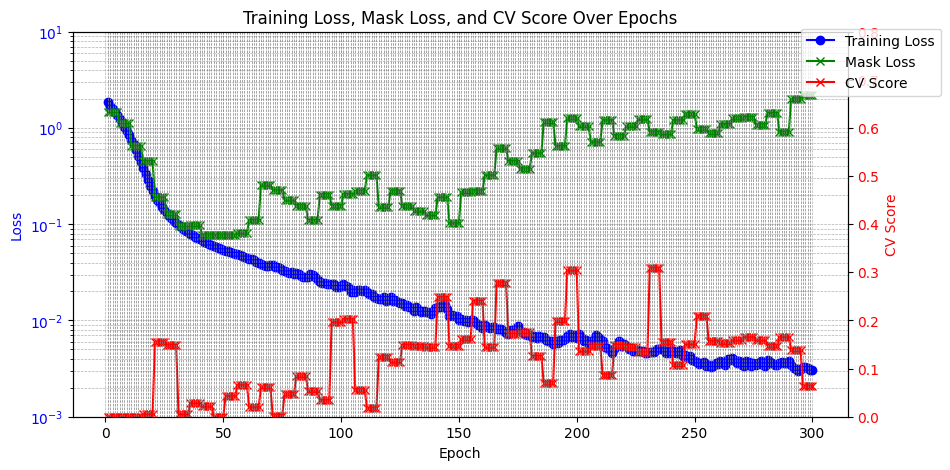

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [13]:
num_epochs = 100
learning_rate = 1e-4
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)
global_step = 0

for epoch in range(num_epochs):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/100
----------
train_loss: 0.0032
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.4870
CVスコア 0.1394
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  68   94   33   0.485294  0.351064  0.356870
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  82   36    0   0.000000  0.000000  0.000000
3             ribosome  88  139   28   0.318182  0.201439  0.205882
4        thyroglobulin  59   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  85   23   11   0.129412  0.478261  0.412804
エポック 2/100
----------
train_loss: 0.0029
エポック 3/100
----------
train_loss: 0.0028
エポック 4/100
----------
train_loss: 0.0026
エポック 5/100
----------
train_loss: 0.0025
エポック 6/100
----------
train_loss: 0.0026
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.5276
CVスコア 0.0749
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  31   94   19   0.612903  0.202128  0.210423
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  68   36    0   0.000000  0.000000  0.000000
3             ribosome  43  139    9   0.209302  0.064748  0.067490
4        thyroglobulin  16   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  46   23    6   0.130435  0.260870  0.246377
エポック 7/100
----------
train_loss: 0.0025
エポック 8/100
----------
train_loss: 0.0024
エポック 9/100
----------
train_loss: 0.0024
エポック 10/100
----------
train_loss: 0.0023
エポック 11/100
----------
train_loss: 0.0022
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.8182
CVスコア 0.0737
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   71   94   18   0.253521  0.191489  0.194286
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  146   36    0   0.000000  0.000000  0.000000
3             ribosome   44  139   10   0.227273  0.071942  0.074956
4        thyroglobulin   28   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   46   23    6   0.130435  0.260870  0.246377
エポック 12/100
----------
train_loss: 0.0023
エポック 13/100
----------
train_loss: 0.0022
エポック 14/100
----------
train_loss: 0.0022
エポック 15/100
----------
train_loss: 0.0022
エポック 16/100
----------
train_loss: 0.0022
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.8491
CVスコア 0.1345
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  67   94   31   0.462687  0.329787  0.335455
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  47   36    0   0.000000  0.000000  0.000000
3             ribosome  81  139   24   0.296296  0.172662  0.177007
4        thyroglobulin  22   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  68   23   11   0.161765  0.478261  0.428899
エポック 17/100
----------
train_loss: 0.0021
エポック 18/100
----------
train_loss: 0.0021
エポック 19/100
----------
train_loss: 0.0022
エポック 20/100
----------
train_loss: 0.0022
エポック 21/100
----------
train_loss: 0.0021
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.5227
CVスコア 0.1517
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  79   94   29   0.367089  0.308511  0.311434
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  40   36    0   0.000000  0.000000  0.000000
3             ribosome  87  139   35   0.402299  0.251799  0.257464
4        thyroglobulin  14   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  80   23   13   0.162500  0.565217  0.493304
エポック 22/100
----------
train_loss: 0.0020
エポック 23/100
----------
train_loss: 0.0021
エポック 24/100
----------
train_loss: 0.0020
エポック 25/100
----------
train_loss: 0.0020
エポック 26/100
----------
train_loss: 0.0020
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.9494
CVスコア 0.1681
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   66   94   30   0.454545  0.319149  0.324841
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   47   36    0   0.000000  0.000000  0.000000
3             ribosome  120  139   62   0.516667  0.446043  0.449659
4        thyroglobulin   13   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  181   23   13   0.071823  0.565217  0.402550
エポック 27/100
----------
train_loss: 0.0021
エポック 28/100
----------
train_loss: 0.0019
エポック 29/100
----------
train_loss: 0.0020
エポック 30/100
----------
train_loss: 0.0020
エポック 31/100
----------
train_loss: 0.0019
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.6553
CVスコア 0.0767
         particle_type   P    T  hit  precision    recall   f-beta4
0         apo-ferritin  73   94   18   0.246575  0.191489  0.194039
1         beta-amylase   0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  84   36    0   0.000000  0.000000  0.000000
3             ribosome  27  139    8   0.296296  0.057554  0.060418
4        thyroglobulin  25   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  53   23    7   0.132075  0.304348  0.282660
エポック 32/100
----------
train_loss: 0.0019
エポック 33/100
----------
train_loss: 0.0020
エポック 34/100
----------
train_loss: 0.0019
エポック 35/100
----------
train_loss: 0.0019
エポック 36/100
----------
train_loss: 0.0019
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.3499
CVスコア 0.1528
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   90   94   29   0.322222  0.308511  0.309285
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   51   36    0   0.000000  0.000000  0.000000
3             ribosome  104  139   42   0.403846  0.302158  0.306701
4        thyroglobulin    7   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  119   23   13   0.109244  0.565217  0.453799
エポック 37/100
----------
train_loss: 0.0018
エポック 38/100
----------
train_loss: 0.0019
エポック 39/100
----------
train_loss: 0.0019
エポック 40/100
----------
train_loss: 0.0018
エポック 41/100
----------
train_loss: 0.0018
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.6549
CVスコア 0.1492
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin   81   94   29   0.358025  0.308511  0.311041
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   91   36    0   0.000000  0.000000  0.000000
3             ribosome  103  139   36   0.349515  0.258993  0.263000
4        thyroglobulin   15   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  102   23   13   0.127451  0.565217  0.470213
エポック 42/100
----------
train_loss: 0.0018
エポック 43/100
----------
train_loss: 0.0018
エポック 44/100
----------
train_loss: 0.0019
エポック 45/100
----------
train_loss: 0.0018
エポック 46/100
----------
train_loss: 0.0019
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.5089
CVスコア 0.1542
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  147   94   29   0.197279  0.308511  0.298607
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   67   36    0   0.000000  0.000000  0.000000
3             ribosome   83  139   41   0.493976  0.294964  0.302124
4        thyroglobulin   26   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   94   23   13   0.138298  0.565217  0.478355
エポック 47/100
----------
train_loss: 0.0018
エポック 48/100
----------
train_loss: 0.0018
エポック 49/100
----------
train_loss: 0.0017
エポック 50/100
----------
train_loss: 0.0018
エポック 51/100
----------
train_loss: 0.0018
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 1.6597
CVスコア 0.1642
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  109   94   29   0.266055  0.308511  0.305642
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   27   36    0   0.000000  0.000000  0.000000
3             ribosome  119  139   63   0.529412  0.453237  0.457106
4        thyroglobulin   28   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  204   23   13   0.063725  0.565217  0.386364
エポック 52/100
----------
train_loss: 0.0017
エポック 53/100
----------
train_loss: 0.0017
エポック 54/100
----------
train_loss: 0.0017
エポック 55/100
----------
train_loss: 0.0017
エポック 56/100
----------
train_loss: 0.0018
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 3.3269
CVスコア 0.1316
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  273   94   31   0.113553  0.329787  0.296567
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  249   36    0   0.000000  0.000000  0.000000
3             ribosome   59  139   25   0.423729  0.179856  0.186159
4        thyroglobulin   50   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   97   23   12   0.123711  0.521739  0.438710
エポック 57/100
----------
train_loss: 0.0017
エポック 58/100
----------
train_loss: 0.0018
エポック 59/100
----------
train_loss: 0.0018
エポック 60/100
----------
train_loss: 0.0016
エポック 61/100
----------
train_loss: 0.0016
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 3.5010
CVスコア 0.0852
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  230   94   24   0.104348  0.255319  0.235294
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  302   36    0   0.000000  0.000000  0.000000
3             ribosome   37  139   10   0.270270  0.071942  0.075188
4        thyroglobulin   32   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   48   23    7   0.145833  0.304348  0.286058
エポック 62/100
----------
train_loss: 0.0016
エポック 63/100
----------
train_loss: 0.0016
エポック 64/100
----------
train_loss: 0.0016
エポック 65/100
----------
train_loss: 0.0016
エポック 66/100
----------
train_loss: 0.0016
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 5.2396
CVスコア 0.0198
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin   897   94   12   0.013378  0.127660  0.084965
1         beta-amylase     0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  3575   36    0   0.000000  0.000000  0.000000
3             ribosome     4  139    1   0.250000  0.007194  0.007630
4        thyroglobulin     2   79    0   0.000000  0.000000  0.000000
5  virus-like-particle     3   23    1   0.333333  0.043478  0.045822
エポック 67/100
----------
train_loss: 0.0016
エポック 68/100
----------
train_loss: 0.0016
エポック 69/100
----------
train_loss: 0.0016
エポック 70/100
----------
train_loss: 0.0017
エポック 71/100
----------
train_loss: 0.0017
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 3.5222
CVスコア 0.1295
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  583   94   29   0.049743  0.308511  0.236224
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  337   36    1   0.002967  0.027778  0.018620
3             ribosome   73  139   30   0.410959  0.215827  0.222029
4        thyroglobulin   79   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   87   23   11   0.126437  0.478261  0.410989
エポック 72/100
----------
train_loss: 0.0016
エポック 73/100
----------
train_loss: 0.0016
エポック 74/100
----------
train_loss: 0.0015
エポック 75/100
----------
train_loss: 0.0016
エポック 76/100
----------
train_loss: 0.0015
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 2.8636
CVスコア 0.1377
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  166   94   30   0.180723  0.319149  0.305389
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   42   36    0   0.000000  0.000000  0.000000
3             ribosome   70  139   32   0.457143  0.230216  0.237140
4        thyroglobulin   59   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  116   23   12   0.103448  0.521739  0.421488
エポック 77/100
----------
train_loss: 0.0015
エポック 78/100
----------
train_loss: 0.0015
エポック 79/100
----------
train_loss: 0.0015
エポック 80/100
----------
train_loss: 0.0015
エポック 81/100
----------
train_loss: 0.0015
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 4.9591
CVスコア 0.0090
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin  3932   94    3   0.000763  0.031915  0.009382
1         beta-amylase     0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  6626   36    0   0.000000  0.000000  0.000000
3             ribosome    18  139    1   0.055556  0.007194  0.007583
4        thyroglobulin     9   79    0   0.000000  0.000000  0.000000
5  virus-like-particle     4   23    1   0.250000  0.043478  0.045699
エポック 82/100
----------
train_loss: 0.0014
エポック 83/100
----------
train_loss: 0.0014
エポック 84/100
----------
train_loss: 0.0015
エポック 85/100
----------
train_loss: 0.0015
エポック 86/100
----------
train_loss: 0.0014
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 3.8396
CVスコア 0.1255
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  182   94   29   0.159341  0.308511  0.292408
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  196   36    1   0.005102  0.027778  0.022021
3             ribosome   47  139   17   0.361702  0.122302  0.127257
4        thyroglobulin   44   79    0   0.000000  0.000000  0.000000
5  virus-like-particle   83   23   11   0.132530  0.478261  0.414634
エポック 87/100
----------
train_loss: 0.0014
エポック 88/100
----------
train_loss: 0.0014
エポック 89/100
----------
train_loss: 0.0014
エポック 90/100
----------
train_loss: 0.0015
エポック 91/100
----------
train_loss: 0.0015
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 5.6307
CVスコア 0.0584
         particle_type     P    T  hit  precision    recall   f-beta4
0         apo-ferritin   888   94   19   0.021396  0.202128  0.135033
1         beta-amylase     0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1476   36    1   0.000678  0.027778  0.008285
3             ribosome    17  139    5   0.294118  0.035971  0.037929
4        thyroglobulin    10   79    0   0.000000  0.000000  0.000000
5  virus-like-particle    20   23    5   0.250000  0.217391  0.219072
エポック 92/100
----------
train_loss: 0.0015
エポック 93/100
----------
train_loss: 0.0015
エポック 94/100
----------
train_loss: 0.0014
エポック 95/100
----------
train_loss: 0.0014
エポック 96/100
----------
train_loss: 0.0014
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 2.8894
CVスコア 0.1547
         particle_type    P    T  hit  precision    recall   f-beta4
0         apo-ferritin  145   94   28   0.193103  0.297872  0.288660
1         beta-amylase    0   30    0   0.000000  0.000000  0.000000
2   beta-galactosidase   37   36    0   0.000000  0.000000  0.000000
3             ribosome   91  139   53   0.582418  0.381295  0.389201
4        thyroglobulin   62   79    0   0.000000  0.000000  0.000000
5  virus-like-particle  178   23   13   0.073034  0.565217  0.404762
エポック 97/100
----------
train_loss: 0.0014
エポック 98/100
----------
train_loss: 0.0014
エポック 99/100
----------
train_loss: 0.0014
エポック 100/100
----------
train_loss: 0.0015


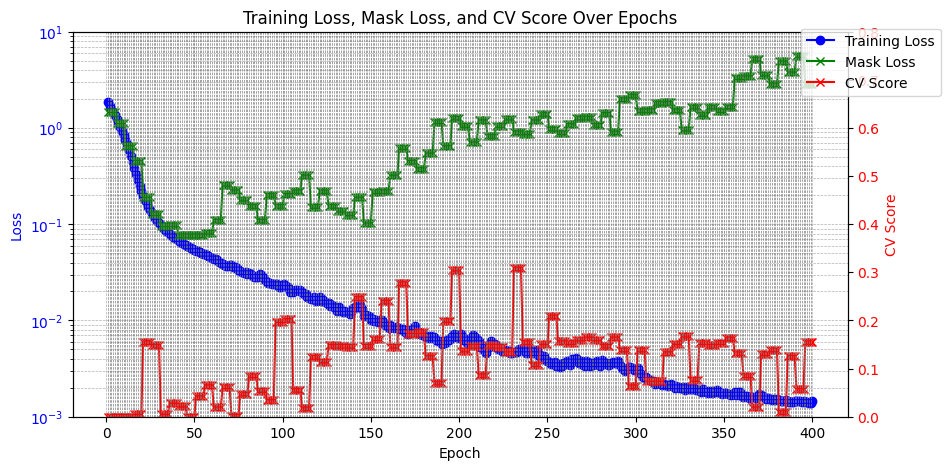

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示S
plt.show()

In [15]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

(3, 184, 630, 630)
(3, 184, 630, 630)


Text(0.5, 1.0, 'truth')

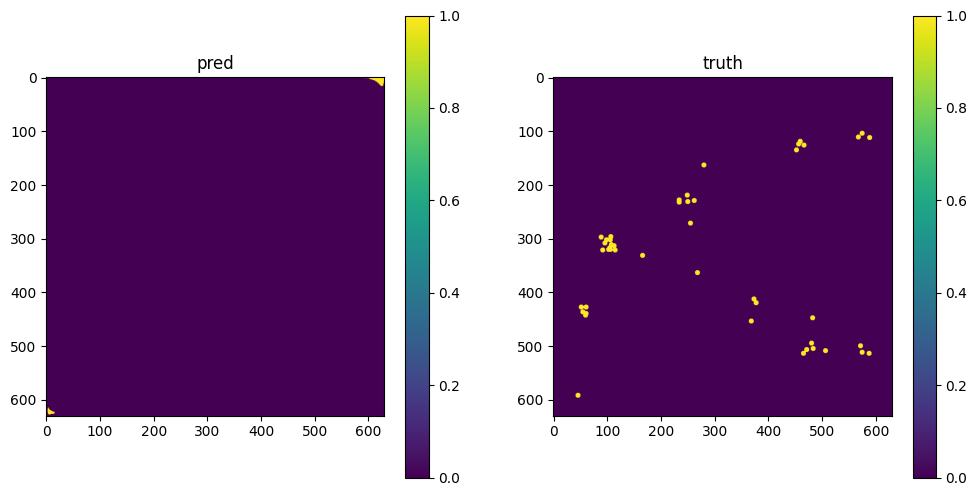

In [16]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.01)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[0,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')